# 과적합 해결

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split   # DataLoader: 주어진 dataset을 미니배치로 묶어줌. random_split: 무작위로 학습, 검증 분리 
import torchvision.transforms as transforms             # torchvision: 딥러닝 이미지 task, transforms: 이미지 스케일링, 정규화 처리 변환 등
import torchvision.datasets as datasets                 # datasets: 이미지로 구성된 datasets

### 배치 정규화 적용

In [2]:
# ToTenser(): 이미지를 pytorch에서 사용할 수 있는 tensor 형태로 변환
# Normalize: 평균 0.5, 표준편차 0.5으로 정규화 수행
# Compose: 수행할 작업을 순차적으로 할 수 있도록

# 데이터셋 로드
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5,))])

# MNIST: 대표적인 이미지 데이터 중 하나 (손글씨로 쓴 숫자)
# root에 저장
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [3]:
# 학습셋-검증셋 사이즈 지정
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# 데이터 분리 및 미니 배치로 로드 가능하도록 DataLoader 생성
train_data, val_data = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [4]:
# 배치 정규화 반영된 간단한 신경망 구조
class SimpleNN(nn.Module):
    def __init__(self, use_bn=False):   # use_bn: batch Normalization
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)                              # 완전 연결층
        self.bn1 = nn.BatchNorm1d(128) if use_bn else nn.Identity()     # Batch Normalization층    Identity(): 아무것도 안함
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64) if use_bn else nn.Identity()  
        self.fc3 = nn.Linear(64, 10)                                    # 10차원으로 출력층

    def forward(self, x):
        x = x.view(x.size(0), -1)                       # (배치 크기, h, w) -> (배치 크기, feature)
        x = torch.relu(self.bn1(self.fc1(x)))   
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x    # 내부적으로 softmax 처리 해줌

In [5]:
def train(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:             # X: 이미지, y: 어떤 숫자인지
            images = images.view(images.size(0), -1)    # 평탄화
            optimizer.zero_grad()                       # 기울기 초기화
            outputs = model(images)                     # 순전파(모델 호출 -> forward)
            loss = criterion(outputs, labels)           # 손실값
            loss.backward()                             # 손실값 역전파
            optimizer.step()                            # 역전파한 가중치 업데이트

        # 검증
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()   # 손실값 누산
                preds = outputs.argmax(dim=1)                   # 예측값
                correct += (preds == labels).sum().item()

        print(f'Epoch {epoch+1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [6]:
print("배치 정규화 적용 안함")
model_without_bn = SimpleNN(use_bn=False)
train(model_without_bn, train_loader, val_loader)

print()
print("배치 정규화 적용")
model_without_bn = SimpleNN(use_bn=True)
train(model_without_bn, train_loader, val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2752, Accuracy: 0.9194
Epoch 2 | Val Loss: 0.2010, Accuracy: 0.9381
Epoch 3 | Val Loss: 0.1661, Accuracy: 0.9484
Epoch 4 | Val Loss: 0.1482, Accuracy: 0.9546
Epoch 5 | Val Loss: 0.1239, Accuracy: 0.9595

배치 정규화 적용
Epoch 1 | Val Loss: 0.1235, Accuracy: 0.9647
Epoch 2 | Val Loss: 0.0993, Accuracy: 0.9698
Epoch 3 | Val Loss: 0.0930, Accuracy: 0.9697
Epoch 4 | Val Loss: 0.0811, Accuracy: 0.9744
Epoch 5 | Val Loss: 0.0781, Accuracy: 0.9760


- 배치 사이즈별 모델 학습 결과

In [7]:
# 배치 사이즈 잘 판단
for batch_size in [16, 32, 128]:
    print(f"batch size: {batch_size}")
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    model = SimpleNN(use_bn=True)
    train(model, train_loader, val_loader)

batch size: 16
Epoch 1 | Val Loss: 0.1176, Accuracy: 0.9638
Epoch 2 | Val Loss: 0.1032, Accuracy: 0.9683
Epoch 3 | Val Loss: 0.0859, Accuracy: 0.9716
Epoch 4 | Val Loss: 0.0942, Accuracy: 0.9709
Epoch 5 | Val Loss: 0.0797, Accuracy: 0.9765
batch size: 32
Epoch 1 | Val Loss: 0.1228, Accuracy: 0.9618
Epoch 2 | Val Loss: 0.0983, Accuracy: 0.9688
Epoch 3 | Val Loss: 0.0956, Accuracy: 0.9704
Epoch 4 | Val Loss: 0.0806, Accuracy: 0.9754
Epoch 5 | Val Loss: 0.0742, Accuracy: 0.9779
batch size: 128
Epoch 1 | Val Loss: 0.1443, Accuracy: 0.9577
Epoch 2 | Val Loss: 0.1124, Accuracy: 0.9649
Epoch 3 | Val Loss: 0.1012, Accuracy: 0.9667
Epoch 4 | Val Loss: 0.0873, Accuracy: 0.9720
Epoch 5 | Val Loss: 0.0925, Accuracy: 0.9706


### 드롭아웃 적용

In [8]:
# 드롭아웃 반영된 간단한 신경망
class DropoutNN(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)          # 128개의 은닉층 노드
        self.dropout1 = nn.Dropout(dropout_rate)    # 비활성화. 훈련 상황에서만 동작. 검증, test 예측에서는 X
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [9]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# 드롭아웃 비율에 따른 성능 변화
for rate in [0.2, 0.5, 0.8]:
    print(f"Dropout Rate: {rate}")
    model = DropoutNN(dropout_rate=rate)
    train(model, train_loader, val_loader)

# 대부분의 뉴런을 끄면 성능이 떨어짐
# 0.5는 성능 괜찮 -> 과대적합 방지

Dropout Rate: 0.2
Epoch 1 | Val Loss: 0.2508, Accuracy: 0.9229
Epoch 2 | Val Loss: 0.1840, Accuracy: 0.9433
Epoch 3 | Val Loss: 0.1563, Accuracy: 0.9513
Epoch 4 | Val Loss: 0.1428, Accuracy: 0.9571
Epoch 5 | Val Loss: 0.1238, Accuracy: 0.9617
Dropout Rate: 0.5
Epoch 1 | Val Loss: 0.3330, Accuracy: 0.9016
Epoch 2 | Val Loss: 0.2898, Accuracy: 0.9153
Epoch 3 | Val Loss: 0.2638, Accuracy: 0.9227
Epoch 4 | Val Loss: 0.2360, Accuracy: 0.9289
Epoch 5 | Val Loss: 0.2286, Accuracy: 0.9312
Dropout Rate: 0.8
Epoch 1 | Val Loss: 1.5166, Accuracy: 0.6019
Epoch 2 | Val Loss: 1.3497, Accuracy: 0.6327
Epoch 3 | Val Loss: 1.3517, Accuracy: 0.6422
Epoch 4 | Val Loss: 1.2630, Accuracy: 0.6587
Epoch 5 | Val Loss: 1.2714, Accuracy: 0.6361


In [10]:
# 모델 다시 설정
model = DropoutNN(dropout_rate=0.2)

In [11]:
# evaluation 모드
# 드롭아웃은 학습 시에만 적용됨
model.eval()
with torch.no_grad():
    images, _ = next(iter(val_loader))          # 검증 데이터 배치 단위로 끊기 반복
    images = images.view(images.size(0), -1)

    out1 = model(images)
    out2 = model(images)

    print(torch.allclose(out1, out2))           # tensor값이 유사한지
    # 드롭아웃이 적용되지 않으므로 매번 같은 출력을 냄

True


In [12]:
# train모드로 변경
model.train()

out1 = model(images)
out2 = model(images)

print(torch.allclose(out1, out2))       # --> False 위에서는 True
# dropout이 적용 됐다/안됐다의 근거

False


### Learning Rate Scheduler 적용

In [13]:
# Learning Rate Scheduler: Learning Rate를 늘리거나 줄이면서 효과적인 학습을 하게 도와줌

# 간단한 신경망 구조
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [14]:
def train_lr(model, train_loader, val_loader, optimizer, scheduler, epochs=10):
    criterion = nn.CrossEntropyLoss()   # 손실함수 만들기

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:             # X: 이미지, y: 어떤 숫자인지
            images = images.view(images.size(0), -1)    # 평탄화
            optimizer.zero_grad()                       # 기울기 초기화
            outputs = model(images)                     # 순전파(모델 호출 -> forward)
            loss = criterion(outputs, labels)           # 손실값
            loss.backward()                             # 손실값 역전파
            optimizer.step()                            # 역전파한 가중치 업데이트

        # 검증
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()   # 손실값 누산
                preds = outputs.argmax(dim=1)                   # 예측값
                correct += (preds == labels).sum().item()
        
        # 학습율 스케쥴러 적용
        scheduler.step()
        print(f'Epoch {epoch+1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [15]:
model = RealSimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)    # step_size=3: epoch 3번마다 학습률 조절, gamma=0.1: lr에 0.1 곱해줌

# scheduler 반영해서 train
train_lr(model, train_loader, val_loader, optimizer, scheduler)

Epoch 1 | Val Loss: 0.3342, Accuracy: 0.9048
Epoch 2 | Val Loss: 0.3114, Accuracy: 0.9127
Epoch 3 | Val Loss: 0.2322, Accuracy: 0.9377
Epoch 4 | Val Loss: 0.1638, Accuracy: 0.9517
Epoch 5 | Val Loss: 0.1612, Accuracy: 0.9543
Epoch 6 | Val Loss: 0.1525, Accuracy: 0.9552
Epoch 7 | Val Loss: 0.1482, Accuracy: 0.9548
Epoch 8 | Val Loss: 0.1469, Accuracy: 0.9561
Epoch 9 | Val Loss: 0.1463, Accuracy: 0.9560
Epoch 10 | Val Loss: 0.1463, Accuracy: 0.9561


### 조기 종료

In [16]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        # --> train 절차

        # 검증 모드
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():       # 기울기 계산 하지 않음
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch+1} | Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        # 조기 종료 반영
        # 기본적으로 조기 종료 설정, early_stopping(val_loss): __call__
        if early_stopping and early_stopping(val_loss):
            print(f"조기종료 epoch {epoch+1}")      # 5번 이상 참은 상태, 조기 종료
            break

    return train_losses, val_losses

In [17]:
# 조기 종료를 위한 클래스(객체)
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience        # 몇번 참을지
        self.min_delta = min_delta      # 최소한의 차이점
        self.best_loss = float('inf')   # 최적의 손실값. float('inf')-> 양의 무한대
        self.counter = 0                

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1       # 카운터가 계속 올라간다 == 손실값이 변화 X
        
        return self.counter >= self.patience        # True or False 반환 받아 학습 중단

In [19]:
print("Early Stopping 적용 안함")
model_no_es = RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses, val_losses = train_es(model_no_es, train_loader, val_loader, optim_no_es)

print()
print("Early Stopping 적용")
model_es = RealSimpleNN()
optim_es = optim.Adam(model_es.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=5)
train_es_losses, val_es_losses = train_es(model_es, train_loader, val_loader, optim_es, early_stopping=early_stopping)

Early Stopping 적용 안함
Epoch 1 | Val Loss: 0.3072, Accuracy: 0.9058
Epoch 2 | Val Loss: 0.2120, Accuracy: 0.9378
Epoch 3 | Val Loss: 0.2596, Accuracy: 0.9217
Epoch 4 | Val Loss: 0.2309, Accuracy: 0.9327
Epoch 5 | Val Loss: 0.2818, Accuracy: 0.9280
Epoch 6 | Val Loss: 0.2320, Accuracy: 0.9347
Epoch 7 | Val Loss: 0.3077, Accuracy: 0.9253
Epoch 8 | Val Loss: 0.2651, Accuracy: 0.9318
Epoch 9 | Val Loss: 0.2067, Accuracy: 0.9462
Epoch 10 | Val Loss: 0.2397, Accuracy: 0.9402
Epoch 11 | Val Loss: 0.2230, Accuracy: 0.9418
Epoch 12 | Val Loss: 0.2592, Accuracy: 0.9302
Epoch 13 | Val Loss: 0.2281, Accuracy: 0.9434
Epoch 14 | Val Loss: 0.3049, Accuracy: 0.9199
Epoch 15 | Val Loss: 0.2743, Accuracy: 0.9317
Epoch 16 | Val Loss: 0.2398, Accuracy: 0.9380
Epoch 17 | Val Loss: 0.2232, Accuracy: 0.9469
Epoch 18 | Val Loss: 0.2744, Accuracy: 0.9313
Epoch 19 | Val Loss: 0.2915, Accuracy: 0.9264
Epoch 20 | Val Loss: 0.2229, Accuracy: 0.9434
Epoch 21 | Val Loss: 0.2283, Accuracy: 0.9458
Epoch 22 | Val Loss: 0

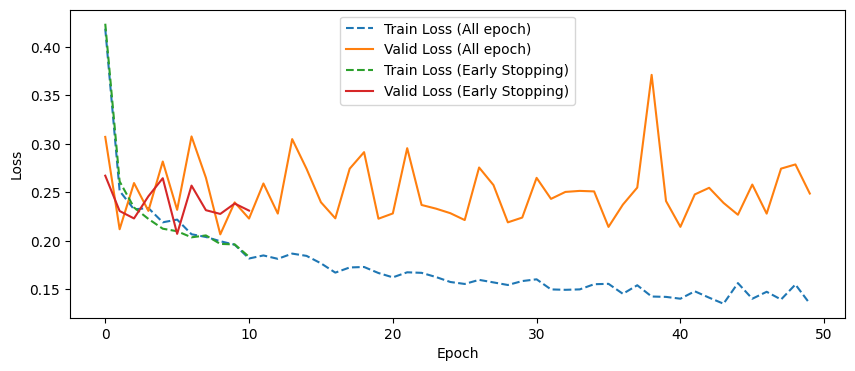

In [20]:
# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss (All epoch)", linestyle='dashed')
plt.plot(val_losses, label="Valid Loss (All epoch)")
plt.plot(train_es_losses, label="Train Loss (Early Stopping)", linestyle="dashed")
plt.plot(val_es_losses, label="Valid Loss (Early Stopping)")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### L2 적용

In [25]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=10):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    weight_norms = []       # 가중치 감쇄 기울기 추적

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        # --> train 절차

        # 검증 모드
        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():       # 기울기 계산 하지 않음
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_data)

        print(f'Epoch {epoch+1} | Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        weight_norm = sum(torch.norm(p).item() for p in model.parameters())        # norm: 가지고 있는 파라미터의 크기
        weight_norms.append(weight_norm)

    return train_losses, val_losses, weight_norms

In [26]:
print("L2 정규화 적용 안함")
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_es.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)
train_losses, val_losses, weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

print()
print("L2 정규화 적용")
model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
train_reg_losses, val_reg_losses, weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)

L2 정규화 적용 안함
Epoch 1 | Val Loss: 2.3000, Accuracy: 0.1092
Epoch 2 | Val Loss: 2.3000, Accuracy: 0.1092
Epoch 3 | Val Loss: 2.3000, Accuracy: 0.1092
Epoch 4 | Val Loss: 2.3000, Accuracy: 0.1092
Epoch 5 | Val Loss: 2.3000, Accuracy: 0.1092
Epoch 6 | Val Loss: 2.3000, Accuracy: 0.1092
Epoch 7 | Val Loss: 2.3000, Accuracy: 0.1092
Epoch 8 | Val Loss: 2.3000, Accuracy: 0.1092
Epoch 9 | Val Loss: 2.3000, Accuracy: 0.1092
Epoch 10 | Val Loss: 2.3000, Accuracy: 0.1092

L2 정규화 적용
Epoch 1 | Val Loss: 0.3039, Accuracy: 0.9123
Epoch 2 | Val Loss: 0.2518, Accuracy: 0.9287
Epoch 3 | Val Loss: 0.2177, Accuracy: 0.9399
Epoch 4 | Val Loss: 0.2101, Accuracy: 0.9422
Epoch 5 | Val Loss: 0.2371, Accuracy: 0.9364
Epoch 6 | Val Loss: 0.2020, Accuracy: 0.9443
Epoch 7 | Val Loss: 0.2015, Accuracy: 0.9416
Epoch 8 | Val Loss: 0.2048, Accuracy: 0.9437
Epoch 9 | Val Loss: 0.2028, Accuracy: 0.9405
Epoch 10 | Val Loss: 0.1926, Accuracy: 0.9466


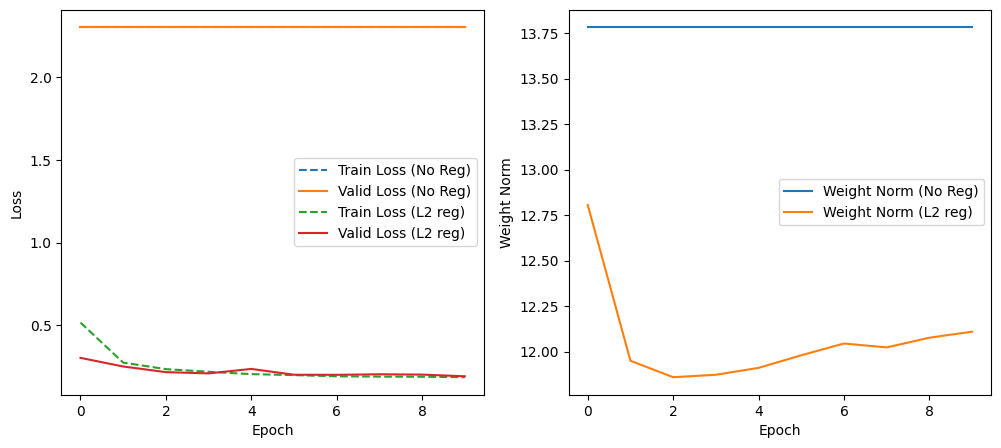

In [28]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (No Reg)', linestyle='dashed')
plt.plot(val_losses, label='Valid Loss (No Reg)')
plt.plot(train_reg_losses, label='Train Loss (L2 reg)', linestyle='dashed')
plt.plot(val_reg_losses, label='Valid Loss (L2 reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(weight_norms, label="Weight Norm (No Reg)")
plt.plot(weight_norms_reg, label="Weight Norm (L2 reg)")
plt.xlabel("Epoch")
plt.ylabel("Weight Norm")
plt.legend()

plt.show()